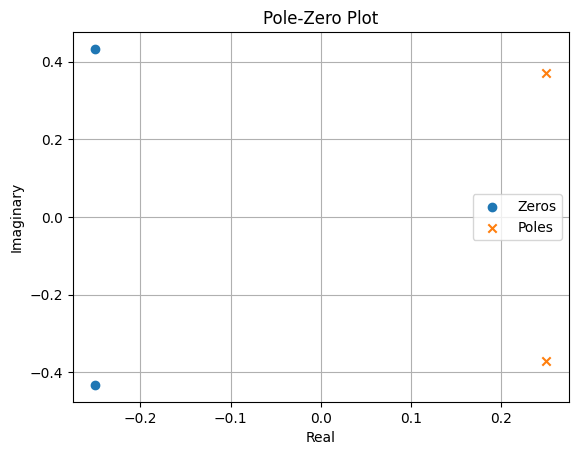

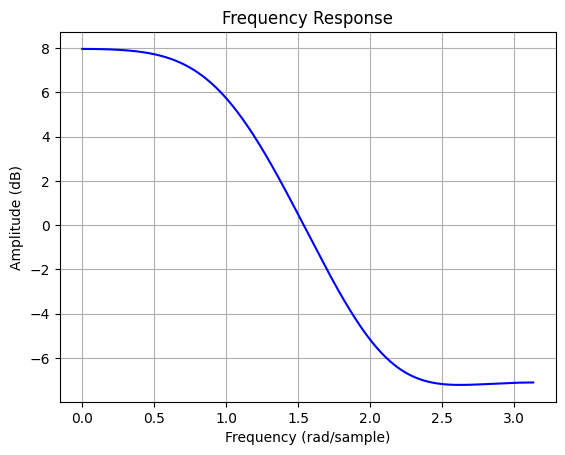

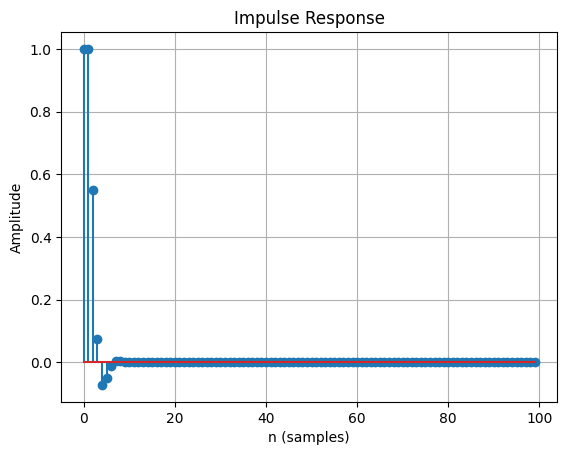

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import tf2zpk, freqz, dimpulse

class ZTransformCalculator:
    def __init__(self):
        self.numerator = []
        self.denominator = []

    def set_coefficients(self, numerator, denominator):
        self.numerator = numerator
        self.denominator = denominator

    def calculate_z_transform(self):
        return np.polyval(self.numerator, 1), np.polyval(self.denominator, 1)

    def plot_pole_zero(self):
        zeros, poles, _ = tf2zpk(self.numerator, self.denominator)
        plt.figure()
        plt.scatter(np.real(zeros), np.imag(zeros), marker='o', label='Zeros')
        plt.scatter(np.real(poles), np.imag(poles), marker='x', label='Poles')
        plt.xlabel('Real')
        plt.ylabel('Imaginary')
        plt.title('Pole-Zero Plot')
        plt.legend()
        plt.grid()
        plt.show()

    def plot_frequency_response(self):
        w, h = freqz(self.numerator, self.denominator)
        plt.figure()
        plt.plot(w, 20 * np.log10(abs(h)), 'b')
        plt.title('Frequency Response')
        plt.xlabel('Frequency (rad/sample)')
        plt.ylabel('Amplitude (dB)')
        plt.grid()
        plt.show()

    def plot_impulse_response(self):
        system = (self.numerator, self.denominator, 1)
        t, y = dimpulse(system)
        plt.figure()
        plt.stem(t, np.squeeze(y))
        plt.title('Impulse Response')
        plt.xlabel('n (samples)')
        plt.ylabel('Amplitude')
        plt.grid()
        plt.show()

# Beispielnutzung
calculator = ZTransformCalculator()
calculator.set_coefficients([1, 0.5, 0.25], [1, -0.5, 0.2])
calculator.plot_pole_zero()
calculator.plot_frequency_response()
calculator.plot_impulse_response()


In [11]:
import tkinter as tk
from tkinter import simpledialog, Menu, messagebox
import sympy as sp

class BlockDiagramEditor:
    def __init__(self, root):
        self.root = root
        self.root.title("Blockschaltbild Editor")
        
        self.canvas = tk.Canvas(root, width=800, height=600, bg='white')
        self.canvas.pack()
        
        self.components = []
        self.connections = []
        
        self.selected_component = None
        self.dragging_component = None
        self.start_component = None
        
        self.create_menus()
        self.create_fixed_points()
        self.canvas.bind("<Button-1>", self.on_canvas_click)
        self.canvas.bind("<B1-Motion>", self.on_canvas_drag)
        self.canvas.bind("<ButtonRelease-1>", self.on_canvas_release)
        self.canvas.bind("<Double-1>", self.on_canvas_double_click)
        
    def create_menus(self):
        self.menu = Menu(self.root, tearoff=0)
        self.menu.add_command(label="Eigenschaften ändern", command=self.change_properties)
        self.menu.add_command(label="Löschen", command=self.delete_component)
        self.menu.add_command(label="Verbindung erstellen", command=self.create_connection)
        
    def create_fixed_points(self):
        self.start_point = self.canvas.create_text(50, 300, text="x(k)", font=("Arial", 24), fill="black")
        self.end_point = self.canvas.create_text(750, 300, text="y(k)", font=("Arial", 24), fill="black")
        self.components.extend([self.start_point, self.end_point])
            
    def on_canvas_click(self, event):
        item = self.canvas.find_closest(event.x, event.y)
        if item:
            self.selected_component = item[0]
            self.dragging_component = self.selected_component
        else:
            self.selected_component = None
            self.dragging_component = None
            
    def on_canvas_double_click(self, event):
        item = self.canvas.find_closest(event.x, event.y)
        if item:
            self.selected_component = item[0]
            self.update_menu()
            self.menu.post(event.x_root, event.y_root)
            
    def on_canvas_drag(self, event):
        if self.dragging_component and self.dragging_component not in [self.start_point, self.end_point]:
            self.canvas.move(self.dragging_component, event.x - self.canvas.coords(self.dragging_component)[0], event.y - self.canvas.coords(self.dragging_component)[1])
            self.update_connections()
    
    def on_canvas_release(self, event):
        self.dragging_component = None
    
    def update_menu(self):
        self.menu.delete(0, 'end')
        component_text = self.canvas.itemcget(self.selected_component, 'text')
        if component_text.startswith("*"):
            self.menu.add_command(label="Eigenschaften ändern", command=self.change_properties)
        self.menu.add_command(label="Löschen", command=self.delete_component)
        self.menu.add_command(label="Verbindung erstellen", command=self.create_connection)
    
    def change_properties(self):
        if self.selected_component:
            component_text = self.canvas.itemcget(self.selected_component, 'text')
            if component_text.startswith("*"):
                current_value = component_text[1:] if len(component_text) > 1 else ""
                new_value = simpledialog.askstring("Eigenschaften ändern", "Neuer Faktor:", initialvalue=current_value)
                if new_value is not None:
                    self.canvas.itemconfig(self.selected_component, text=f"*{new_value}")
    
    def delete_component(self):
        if self.selected_component and self.selected_component not in [self.start_point, self.end_point]:
            self.remove_connections(self.selected_component)
            self.canvas.delete(self.selected_component)
            self.selected_component = None
    
    def add_component(self, component_type):
        x, y = 100, 100
        if component_type == "Addition":
            component = self.canvas.create_text(x, y, text="+", font=("Arial", 24), fill="red")
        elif component_type == "Multiplikation":
            component = self.canvas.create_text(x, y, text="*", font=("Arial", 24), fill="blue")
        elif component_type == "Verzögerung":
            component = self.canvas.create_text(x, y, text="z^-1", font=("Arial", 24), fill="green")
        self.components.append(component)
        
    def create_connection(self):
        if self.selected_component:
            if self.start_component is None:
                self.start_component = self.selected_component
                messagebox.showinfo("Verbindung erstellen", "Wählen Sie die Zielkomponente aus.")
            else:
                end_component = self.selected_component
                arrow = self.draw_arrow(self.start_component, end_component)
                self.connections.append((self.start_component, end_component, arrow))
                self.start_component = None
    
    def draw_arrow(self, start_item, end_item):
        start_coords = self.canvas.coords(start_item)
        end_coords = self.canvas.coords(end_item)
        if start_coords and end_coords:
            start_x, start_y = start_coords[0], start_coords[1]
            end_x, end_y = end_coords[0], end_coords[1]
            return self.canvas.create_line(start_x, start_y, end_x, end_y, arrow=tk.LAST)
    
    def update_connections(self):
        for start_item, end_item, arrow in self.connections:
            start_coords = self.canvas.coords(start_item)
            end_coords = self.canvas.coords(end_item)
            if start_coords and end_coords:
                start_x, start_y = start_coords[0], start_coords[1]
                end_x, end_y = end_coords[0], end_coords[1]
                self.canvas.coords(arrow, start_x, start_y, end_x, end_y)
    
    def remove_connections(self, component):
        to_remove = []
        for connection in self.connections:
            start_item, end_item, arrow = connection
            if start_item == component or end_item == component:
                self.canvas.delete(arrow)
                to_remove.append(connection)
        self.connections = [conn for conn in self.connections if conn not in to_remove]
        
    def calculate_transfer_function(self):
        # Beispielhafte Berechnung der Übertragungsfunktion
        x, y, z = sp.symbols('x y z')
        eq = sp.Eq(y, x*z)
        transfer_function = sp.solve(eq, y)
        messagebox.showinfo("Übertragungsfunktion", str(transfer_function))

if __name__ == "__main__":
    root = tk.Tk()
    editor = BlockDiagramEditor(root)
    
    toolbar = tk.Frame(root)
    toolbar.pack(side=tk.TOP, fill=tk.X)
    
    btn_add = tk.Button(toolbar, text="Addition", command=lambda: editor.add_component("Addition"))
    btn_add.pack(side=tk.LEFT)
    btn_mul = tk.Button(toolbar, text="Multiplikation", command=lambda: editor.add_component("Multiplikation"))
    btn_mul.pack(side=tk.LEFT)
    btn_delay = tk.Button(toolbar, text="Verzögerung", command=lambda: editor.add_component("Verzögerung"))
    btn_delay.pack(side=tk.LEFT)
    
    btn_calc = tk.Button(toolbar, text="Übertragungsfunktion", command=editor.calculate_transfer_function)
    btn_calc.pack(side=tk.LEFT)
    
    root.mainloop()


: 